# Principal Curve Examples with WKM

This notebook demonstrates the use of the WKM (Wasserstein K-Means) algorithm for fitting principal curves with different constraints:
1. **Bounded Length**: Principal curves with length constraints
2. **Bounded Curvature**: Principal curves with curvature penalties

The examples use a step-shaped 2D dataset with added noise to showcase how different constraints affect the resulting principal curves.

## Import Required Libraries

Import all necessary libraries for data generation, principal curve fitting, and visualization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from cycler import cycler
import importlib

import sys
import os
# Add the parent directory to Python path for importing wkm
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import wkm

# Set up plotting parameters
color_cycle = ['#E7D046', '#1965B0', '#DC050C', '#F1932D', '#4EB265', '#F6C141'] 
plt.rcParams['text.usetex'] = True
cc = cycler('color', color_cycle)

print("Libraries imported successfully!")

In [86]:
# Auxiliary functions

def rho_step_2d(n):
    """Generate a 2D step-shaped curve with n points."""
    third = int(n/3)
    t = np.concatenate([np.linspace(-1, 0, third), np.zeros(n - 2 * third), np.linspace(0, 1, third)])
    s = np.concatenate([np.zeros(third), np.linspace(0, 1, n - 2 * third), np.ones(third)])
    p = np.vstack([t, s]).T
    return p

def shrink_pca_1d_kmeans(x_pca, m):
    """
    Create m representative points from n PCA projections using 1D k-means approach.
    
    Args:
        x_pca: (n, d) ordered PCA projections
        m: number of desired representative points
    
    Returns:
        x_shrunk: (m, d) representative points
    """
    n, d = x_pca.shape
    
    if m >= n:
        return x_pca
    
    x_shrunk = np.zeros((m, d))
    
    # Compute segment boundaries
    segment_size = n / m
    
    for i in range(m):
        # Calculate start and end indices for this segment
        start_idx = int(i * segment_size)
        end_idx = int((i + 1) * segment_size)
        
        # Handle the last segment to include any remaining points
        if i == m - 1:
            end_idx = n
        
        # Compute barycenter of points in this segment
        segment_points = x_pca[start_idx:end_idx]
        x_shrunk[i] = np.mean(segment_points, axis=0)
    
    return x_shrunk

# pseudo-diagonal transport matrix for rectangular case
def create_pseudo_diagonal_pi(m, n):
    """
    Create a pseudo-diagonal transport matrix for rectangular case (m < n).
    Similar to drawing a diagonal line in a rectangular pixel grid.
    
    Args:
        m: number of clusters (rows)
        n: number of data points (columns)
    
    Returns:
        pi: (m, n) pseudo-diagonal transport matrix
    """
    pi = np.zeros((m, n))
    
    if m == n:
        return np.eye(m) / m
    
    # Create smooth diagonal-like assignment
    for j in range(n):
        # Map column j to the corresponding row using linear interpolation
        row_float = (j * (m - 1)) / (n - 1)
        
        # Get adjacent integer rows
        row_low = int(np.floor(row_float))
        row_high = int(np.ceil(row_float))
        
        # Compute interpolation weights
        weight_high = row_float - row_low
        weight_low = 1.0 - weight_high
        
        # Assign weights (ensuring we don't go out of bounds)
        if row_low < m:
            pi[row_low, j] = weight_low / n
        if row_high < m and row_high != row_low:
            pi[row_high, j] = weight_high / n
        elif row_low == row_high and row_low < m:
            pi[row_low, j] = 1.0 / n
    
    return pi

# Plot
def plot_comprehensive_comparison(data_dict, plot_pca = True):
    """
    Plot comprehensive comparison of K-dominance vs Convex order methods.
    
    Handles both curvature (lambda_values) and bounded length (length_values) parameters.
    
    Style guide:
    - Data points: grey squares
    - PCA points: half-transparent yellow line  
    - KDR solutions: blue and red lines
    - CVX solution: visible points + half-transparent line (same color as last KDR)
    """
    
    fig, ax = plt.subplots(figsize=[6, 5])
    ax.axis('equal')
    
    # Plot data points (grey squares)
    ax.scatter(x=data_dict['data_points'][:,0], y=data_dict['data_points'][:,1], 
              s=14, marker='s', color='black', alpha=0.2, label='Data points')
    
    # Plot PCA line (half-transparent yellow)
    if plot_pca:
        ax.plot(data_dict['pca_points'][:,0], data_dict['pca_points'][:,1], 
                color='yellow', linewidth=2, alpha=0.8, label='PCA')
    
    # Define colors for KDR solutions
    kdr_colors = ['green', 'blue', 'red', 'purple', 'black']
    
    # Determine parameter type and values
    if 'lambda_values' in data_dict:
        param_values = data_dict['lambda_values']
        param_name = 'lambda'
        param_format = lambda x: f'{x}'
        constraint_type = 'Curvature'
    elif 'length_values' in data_dict:
        param_values = data_dict['length_values']
        param_name = 'B'
        param_format = lambda x: f'{x}'
        constraint_type = 'Bounded Length'
    else:
        raise ValueError("Data dictionary must contain either 'lambda_values' or 'length_values'")
    
    # Plot KDR solutions
    for i, (x_kdr, param_val) in enumerate(zip(data_dict['kdr_solutions'], param_values)):
        color = kdr_colors[i % len(kdr_colors)]
        ax.plot(x_kdr[:,0], x_kdr[:,1], 
               color=color, linewidth=2.5, alpha=1.0, 
               label=f'KDR {param_name}={param_format(param_val)}')
    
    # Plot CVX solution (points + line, using next available color)
    cvx_color = kdr_colors[len(data_dict['kdr_solutions']) % len(kdr_colors)]
    cvx_x = data_dict['cvx_solution']
    
    # Plot CVX line (half-transparent)
    ax.plot(cvx_x[:,0], cvx_x[:,1], 
           color=cvx_color, linewidth=2.5, alpha=0.4)
    
    # Plot CVX points (visible)
    ax.scatter(cvx_x[:,0], cvx_x[:,1], 
              color=cvx_color, s=30, alpha=1.0, 
              label=f'CVX {param_name}={param_format(param_values[-1])}', zorder=5)
    
    # Styling - legend inside the plot area
    ax.legend(loc='upper left')
    #ax.set_title(f'K-Dominance vs Convex Order Comparison ({constraint_type})\n'
    #            f'n={data_dict["n"]}, m_KDR={data_dict["m_kdr"]}, m_CVX={data_dict["m_cvx"]}', 
    #            fontsize=14)
    ax.set_xlabel('x1', fontsize=12)
    ax.set_ylabel('x2', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()




## Comprehensive Comparison: K-Dominance vs Convex Order

Generate a comprehensive dataset to compare different methods with varying parameters.

In [ ]:
# Generate comprehensive comparison dataset
importlib.reload(wkm)  # Refresh the wkm library

# Parameters
n = 300
m_kdr = 100  # K-dominance (regular method)
m_cvx = 10   # Convex order (martingale method)
np.random.seed(1)
noise_var = 0.01

# Generate clean step curve
p_full = rho_step_2d(n)

# Add noise to create the dataset
mean = [0 for i in range(2)]
cov = noise_var * np.eye(2)
y_full = np.vstack([p_full[i,:] + np.random.multivariate_normal(mean, np.random.random(2) * cov, size=1) for i in range(n)])

# Compute PCA for initialization
pca_full = PCA(n_components=1)
f_full = pca_full.fit_transform(y_full)
x_pca_full = pca_full.inverse_transform(f_full)
order_full = np.argsort(f_full[:,0])
x_pca_full = x_pca_full[order_full]

# Compute shrunk PCA versions
x_pca_kdr = shrink_pca_1d_kmeans(x_pca_full, m_kdr)
x_pca_cvx = shrink_pca_1d_kmeans(x_pca_full, m_cvx)


In [ ]:
# Fit K-dominance curves with different lambda values
importlib.reload(wkm)  # Refresh the wkm library
lambda_values = [1e-3, 1e-4]
x_kdr_solutions = []

print("Fitting K-dominance curves...")
for i, lam in enumerate(lambda_values):
    print(f"  Fitting KDR curve {i+1}/{len(lambda_values)} with lambda = {lam}")
    
    # Create pseudo-diagonal initialization
    pi0_init = create_pseudo_diagonal_pi(m_kdr, n)
    
    x, pi, exy_series = wkm.fit(y_full, m_kdr, 'curvature', x0=x_pca_kdr, pi0=pi0_init, 
                               epochs=200000, verbose=False, curvature_penalty=lam)
    x_kdr_solutions.append(x)


In [ ]:
# Fit convex order curve with last lambda value
importlib.reload(wkm)  # Refresh the wkm library
print("Fitting convex order curve...")
pi0_cvx = create_pseudo_diagonal_pi(m_cvx, n)
x_cvx_solution, pi_cvx, exy_cvx = wkm.fit(y_full, m_cvx, 'curvature_mtg', x0=x_pca_cvx, pi0=pi0_cvx, 
                                         epochs=50000, verbose=False, curvature_penalty=lambda_values[-1])

Dataset created with:
  - 300 data points
  - 100 KDR curve points
  - 10 CVX curve points
  - 2 lambda values: [0.001, 0.0001]


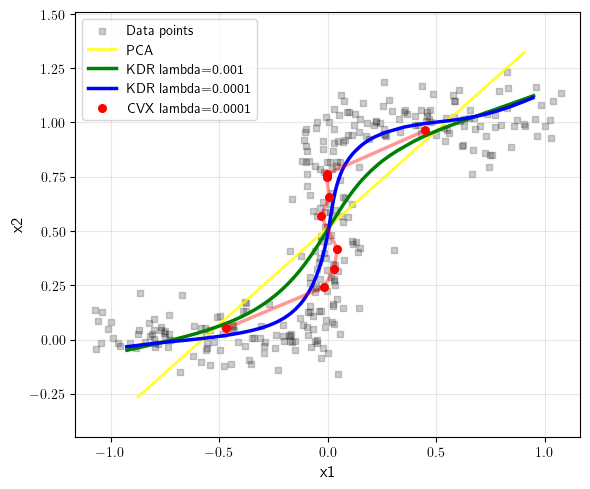

In [87]:
# Create comprehensive dataset dictionary
dataset = {
    'clean_points': p_full,
    'data_points': y_full,
    'pca_points': x_pca_full,
    'pca_kdr_shrunk': x_pca_kdr,
    'pca_cvx_shrunk': x_pca_cvx,
    'kdr_solutions': x_kdr_solutions,
    'cvx_solution': x_cvx_solution,
    'lambda_values': lambda_values,
    'n': n,
    'm_kdr': m_kdr,
    'm_cvx': m_cvx
}

print(f"Dataset created with:")
print(f"  - {n} data points")
print(f"  - {m_kdr} KDR curve points")
print(f"  - {m_cvx} CVX curve points")
print(f"  - {len(lambda_values)} lambda values: {lambda_values}")

# Create the comprehensive comparison plot
plot_comprehensive_comparison(dataset)

In [ ]:
# Save the comprehensive dataset to pickle file
import pickle

# Create filename with parametrized n value
pickle_filename = f'../model_dump/bounded_curvature_n{dataset["n"]}.pickle'

# Save the dataset dictionary
with open(pickle_filename, 'wb') as f:
    pickle.dump(dataset, f)

print(f'Dataset saved to {pickle_filename}')
print(f'Contains:')
print(f'  - {dataset["n"]} data points')
print(f'  - {dataset["m_kdr"]} KDR curve points') 
print(f'  - {dataset["m_cvx"]} CVX curve points')
print(f'  - {len(dataset["lambda_values"])} lambda values: {dataset["lambda_values"]}')

## Comprehensive Comparison: Bounded Length - K-Dominance vs Convex Order

Generate a comprehensive dataset to compare bounded length methods with varying parameters.

In [ ]:
# Fit K-dominance curves with different B values
importlib.reload(wkm)  # Refresh the wkm library
parameter_length = [0.3, 0.6]
x_kdr_length_solutions = []

print("Fitting K-dominance curves with bounded length...")
for i, B in enumerate(parameter_length):
    print(f"  Fitting KDR curve {i+1}/{len(parameter_length)} with B = {B}")
    
    # Create pseudo-diagonal initialization
    pi0_init = create_pseudo_diagonal_pi(m_kdr, n)
    
    x, pi, exy_series = wkm.fit(y_full, m_kdr, 'length', x0=x_pca_kdr, pi0=pi0_init, 
                               epochs=10, verbose=False, length=B)
    x_kdr_length_solutions.append(x)

In [ ]:
# Load convex order curve from pre-computed pickle file
print("Loading convex order curve from pickle file...")
import pickle
import os
pickle_path = os.path.join('..', 'external', 'convex_order_results_B=06_and_n=300_and_m=10.pkl')
with open(pickle_path, 'rb') as f:
    convex_data = pickle.load(f)
    
# Extract the pre-computed curve (already in original scale)
x_cvx_length_solution = convex_data['x_con_plot']

# Centralize the curve to have the same mean as the data
curve_mean = np.mean(x_cvx_length_solution, axis=0)
data_mean = np.mean(y_full, axis=0)
x_cvx_length_solution = x_cvx_length_solution - curve_mean + data_mean

# Create dummy variables for consistency with the rest of the code
pi_cvx_length = None  # Transport matrix not available from pickle
exy_cvx_length = []   # Evolution history not available from pickle

print(f"Loaded and centralized convex order curve with {len(x_cvx_length_solution)} points")
print(f"Original curve mean: {curve_mean}")
print(f"Data mean: {data_mean}")
print(f"New curve mean: {np.mean(x_cvx_length_solution, axis=0)}")

Bounded length dataset created with:
  - 300 data points
  - 100 KDR curve points
  - 10 CVX curve points
  - 2 B values: [0.3, 0.6]


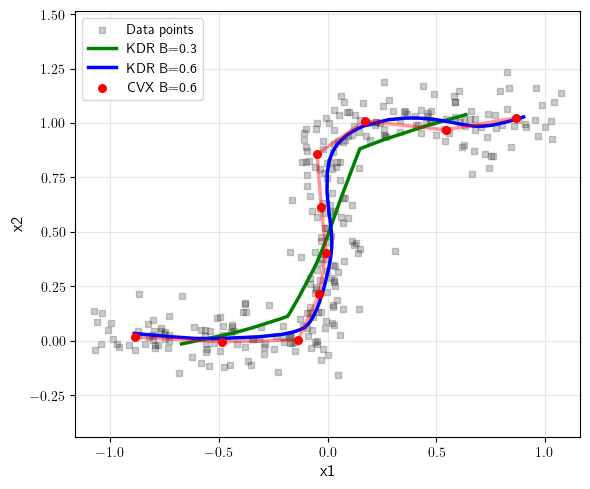

In [88]:
# Create comprehensive dataset dictionary
dataset_length = {
    'clean_points': p_full,
    'data_points': y_full,
    'pca_points': x_pca_full,
    'pca_kdr_shrunk': x_pca_kdr,
    'pca_cvx_shrunk': x_pca_cvx,
    'kdr_solutions': x_kdr_length_solutions,
    'cvx_solution': x_cvx_length_solution,
    'length_values': parameter_length,
    'n': n,
    'm_kdr': m_kdr,
    'm_cvx': m_cvx
}

print(f"Bounded length dataset created with:")
print(f"  - {n} data points")
print(f"  - {m_kdr} KDR curve points")
print(f"  - {m_cvx} CVX curve points")
print(f"  - {len(parameter_length)} B values: {parameter_length}")

# Plot the comprehensive comparison for bounded length
plot_comprehensive_comparison(dataset_length, plot_pca=False)

In [ ]:
# Save the comprehensive bounded length dataset to pickle file
filename_length = 'comprehensive_bounded_length_comparison.pkl'
with open(filename_length, 'wb') as f:
    pickle.dump(dataset_length, f)

print(f"Bounded length dataset saved to {filename_length}")
print(f"File size: {os.path.getsize(filename_length)} bytes")

## Summary and Insights

This notebook demonstrates two different approaches to fitting principal curves:

### Bounded Length Approach
- Controls the total arc length of the curve
- Lower `B` values result in straighter curves
- Higher `B` values allow more flexibility in curve shape

### Bounded Curvature Approach  
- Uses curvature penalties to enforce smoothness
- Lower `λ` values (less penalty) allow sharper turns
- Higher `λ` values (more penalty) enforce smoother curves

### Key Observations
1. Both methods can capture the underlying step structure in the data
2. The bounded length method tends to create piecewise linear approximations
3. The bounded curvature method produces smoother curves
4. Parameter tuning is crucial for balancing fidelity to data vs. regularity constraints

The WKM algorithm provides a flexible framework for optimal transport-based principal curve fitting with various geometric constraints.